# Fine-tuned YAMNet: small plane detection

In [ ]:
#%pylab inline

In [2]:
# system
import sys, os, glob
# progress bars
from tqdm import tqdm
# plots
import matplotlib.pyplot as plt
# data augmentation
import random
import numpy as np
# audio processing
import soundfile as sf
import librosa
import resampy

In [3]:
# add yamnet_base to sys path 
yamnet_base = './yamnet_base/'
assert os.path.exists(yamnet_base)
sys.path.append(yamnet_base)

In [4]:
## YAMNet
import params
import yamnet as yamnet_tf
import modified_yamnet as yamnet
import features as features_lib

In [5]:
# tensorflow and keras
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print("tf version: ", tf.__version__)
print("tf.keras version: ", tf.keras.__version__)


tf version:  2.0.0
tf.keras version:  2.2.4-tf


In [8]:
# OPTION 1
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

# OPTION 2
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range

In [9]:
# Original YAMNet model
params.PATCH_HOP_SECONDS = 0.1  # 10 Hz scores frame rate.

yamnet_model, dense_net = yamnet.yamnet_frames_model(params)
yamnet_model.load_weights('yamnet.h5')

class_names = yamnet_tf.class_names(os.path.join(yamnet_base, 'yamnet_class_map.csv'))

## Function definitions

In [10]:
def read_wav(fname, output_sr, use_rosa=True):
    # small wrapper - i was seeing some slightly different 
    # results when loading with different libraries 
    if use_rosa:
        waveform, sr = librosa.load(fname, sr=output_sr)
    else:
        wav_data, sr = sf.read(fname, dtype=np.int16)
        
        if wav_data.ndim > 1: 
            # (ns, 2)
            wav_data = wav_data.mean(1)
        if sr != output_sr:
            wav_data = resampy.resample(wav_data, sr, output_sr)
        waveform = wav_data / 32768.0
    
    return waveform.astype(np.float64)


In [11]:
def remove_silence(waveform, top_db=15, min_chunk_size=2000, merge_chunks=True):
    # Loads sample into chunks of non-silence 
    
    splits = librosa.effects.split(waveform, top_db=top_db)
    
    waves = []
    for start, end in splits:
        if (end-start) < min_chunk_size:
            continue
        waves.append(waveform[start:end])
    
    if merge_chunks:
        out = None
        for c in waves:
            if out is None:
                out = c.copy()
            else:
                out = np.concatenate((out, c))
        waves = out
    
    return waves


In [12]:
def get_top_dirs(p):
    dirs = list(filter(lambda x : os.path.isdir( os.path.join(p, x) ), os.listdir(p)))
    return list(map(lambda x : os.path.join(p, x), dirs))

In [13]:
def random_augment_wav(wav_data):
    # apply some random augmentations to the sound
    # - time stretch, resample, volume change, minor noise 
    # - this has not been evaluated to measure contributions
    # - TODO: probably a lot more augmentations you could use 
    
    wav_data = wav_data.copy() 
    
    # random re-sample 
    if np.random.uniform() > 0.8:
        stretch = np.random.uniform(0.75, 1.5)
        wav_data = librosa.effects.time_stretch(wav_data, stretch)
    elif np.random.uniform() > 0.2:
        new_sr = int(DESIRED_SR * np.random.uniform(0.9, 1.1))
        wav_data = resampy.resample(wav_data, DESIRED_SR, new_sr)
    
    #librosa.effects.pitch_shift()
    
    # random volume
    volume = np.random.uniform(0.65, 1.2)
    wav_data = wav_data * volume
    
    # Random noise
    if np.random.uniform() > 0.5:
        NR = 0.001 # 0.1
        wav_data += np.random.uniform(-NR, NR, size=wav_data.shape)
    
    return wav_data
    
    

In [14]:
def load_data(base_path, 
              audio_model, 
              num_augmentations=5,
              max_sample_seconds=5.0,
              use_rosa=True):
    """
    Loads data from .wav files contained in subfolders where 
    folder name is label, then runs them 
    through the audio_model to get feature vectors 
    and returns:
    
    X : [ np.array(1024) , ... ]
    Y : [ category_idx , ...]
    
    """
    
    label_dirs = get_top_dirs(base_path)
    
    _samples = []
    _labels = []
    
    merge_chunks = True
    MIN_WAV_SIZE = 5000 # TODO: seems to need to be pretty long for NN to work?
    max_wav_size = int(DESIRED_SR * max_sample_seconds)
    
    for label_idx, label_dir in enumerate(label_dirs):
        
        label_name = os.path.basename(label_dir)
        wavs = glob.glob(os.path.join(label_dir, "*.wav"))
        print(" Loading {:<5} '{:<40}'".format(label_idx, label_name))
        
        for wav_file in tqdm(wavs):
            
            # rosa seems very different?
            #for use_rosa in range(2):
            if True:
                #use_rosa = 1
                #use_rosa = np.random.uniform() > 0.5
                waveform = read_wav(wav_file, DESIRED_SR, use_rosa=use_rosa)

                if label_name == 'train':
                    waveform = remove_silence(waveform)

                if len(waveform) < MIN_WAV_SIZE:
                    continue 

                if len(waveform) > max_wav_size:
                    waveform = waveform[:max_wav_size]
                    print("\nIgnoring audio data after {} seconds".format(max_sample_seconds))

                for aug_idx in range(1 + num_augmentations):
                    
                    aug_wav = waveform.copy()
                    
                    if aug_idx > 0:
                        aug_wav = random_augment_wav(aug_wav)

                    _, _, dense_out, _ = audio_model.predict(np.reshape(aug_wav, [1, -1]), steps=1)
                    
                    for patch in dense_out:
                        _samples.append(patch)
                        _labels.append(label_idx)
                
    return _samples, _labels
    

In [15]:
def run_models(waveform, 
               yamnet_model, 
               top_model, 
               strip_silence=True, 
               min_samples=16000):
    
    if strip_silence:
        waveform = remove_silence(waveform, top_db=10)
    
    if len(waveform) < min_samples:
        print("input too short after silence removal")
        return [-1] #this value will be used to discard this audio later
    
    _, _, dense_out, _ = \
        yamnet_model.predict(np.reshape(waveform, [1, -1]), steps=1)
    
    # dense = (N, 1024)
    all_scores = []
    for patch in dense_out:
        scores = top_model.predict( np.expand_dims(patch,0)).squeeze()
        all_scores.append(scores)
        
    all_scores = np.mean(all_scores, axis=0)
    return all_scores


## YAMNet predictions on a single audio

In [16]:
# Load waveform
# Parameters
DESIRED_SR = 16000 # required by YAMNet
NUM_CLASSES = 2 # (plane, not_plane)

file_name = "/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v0/training_data/plane/track_04_0000_norm.wav"
waveform = read_wav(file_name, DESIRED_SR, use_rosa=1)

# Calculate scores and spectrogram
scores, spectrogram, dense_out, patches = yamnet_model.predict(np.reshape(waveform, [1, -1]), steps=1)

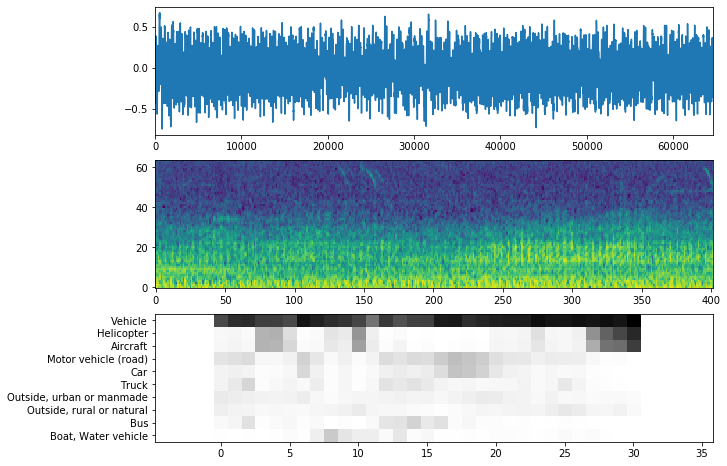

In [17]:
# Visualize the results.
plt.figure(figsize=(10, 8))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='bottom')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_N = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_N]
plt.subplot(3, 1, 3)
plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')
# Compensate for the PATCH_WINDOW_SECONDS (0.96 s) context window to align with spectrogram.
patch_padding = (params.PATCH_WINDOW_SECONDS / 2) / params.PATCH_HOP_SECONDS
plt.xlim([-patch_padding, scores.shape[0] + patch_padding])
# Label the top_N classes.
yticks = range(0, top_N, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_N, 0]))

plt.show()

## Load training data


In [18]:
samples, labels = load_data("/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v0/training_data/",
                            yamnet_model,
                            num_augmentations=4, 
                            max_sample_seconds=5.0)


100%|██████████| 14/14 [00:06<00:00,  2.03it/s]


In [19]:
idxs = list(range(len(labels)))
random.shuffle(idxs)

samples = [samples[i] for i in idxs]
labels = [labels[i] for i in idxs]

samples = np.array(samples)
labels = np.array(labels)

print(" Loaded samples: " , samples.shape, samples.dtype,  labels.shape)


Loaded samples:  (4004, 1024) float32 (4004,)


## Fine tuned model which takes YAMNet's output feature vector as input

In [20]:
# Parameters
DESIRED_SR = 16000 # required by YAMNet
NUM_CLASSES = 2 # (plane, not_plane)

In [21]:
def get_top_model(num_classes=2, 
                  input_size=1024,
                  num_hidden=1024):

    input_layer = layers.Input(shape=(input_size,))
    
    output = layers.Dense(num_hidden, activation=None)(input_layer)

    output = layers.Dense(num_classes, activation='softmax')(output)
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model


In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
save_best = ModelCheckpoint('top_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')


In [22]:
# Classifier definition
num_hidden = 1024
feature_len = 1024

model = get_top_model(num_classes=NUM_CLASSES, 
                      input_size=feature_len, 
                      num_hidden=num_hidden)

#opt = Adam(learning_rate=0.001)
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Train the model 
history = model.fit(samples, labels, epochs=200, validation_split=0.1)
# history = model.fit(samples, labels, epochs=200, validation_split=0.1, callbacks=[save_best])

ample - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 68/200
3603/3603 [==============================] - 0s 77us/sample - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 69/200
3603/3603 [==============================] - 0s 77us/sample - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 70/200
3603/3603 [==============================] - 0s 79us/sample - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 71/200
3603/3603 [==============================] - 0s 78us/sample - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 72/200
3603/3603 [==============================] - 0s 77us/sample - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 73/200
3603/3603 [==============================] - 0s 79us/sample - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 74/200
3603/3603 [

In [ ]:
# a few iterations on all the data
history = model.fit(samples, labels, epochs=5)

## Test on a holdout sound 

In [26]:
model_new = model

In [21]:
# Load model
from tensorflow.keras.models import load_model

model_new = load_model('top_model_v2.h5')
opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_new.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_new.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 1,051,650
Trainable params: 1,051,650
Non-trainable params: 0
_________________________________________________________________


In [27]:
categories = ["not plane", "plane"]
scores = run_models(waveform, yamnet_model, model_new)
winner = categories[scores.argmax()]

print(" Best score: {}  label: {}".format(scores.max(), winner))


Best score: 0.9993128776550293  label: plane


In [30]:
import os
holdout_dir = "/home/ups/Proyectos/Vigia_sonido/Datasets/airplanes_v2/holdout_data/plane/"
arr = os.listdir(holdout_dir)

for fname in arr: 
    fname = holdout_dir+fname
    waveform = read_wav(fname, DESIRED_SR, use_rosa=1)

    # waveform = remove_silence(waveform, top_db=10)

    # make file a bit longer by duplicating it 
    waveform = np.concatenate((waveform,waveform,waveform))

    scores = run_models(waveform, yamnet_model, model_new, strip_silence=False)
    winner_save = np.empty((0,2))
    if scores[0] != -1:
        winner = categories[scores.argmax()]
        print(" Best score: {}  label: {}".format(scores.max(), winner))
        winner_save = np.append(winner_save,np.array([scores.max(),winner]),axis=0)

Best score: 0.9993128776550293  label: plane


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [26]:
result_array = np.empty((0, 2))
result = np.array([1,"a"])
result_array = np.append(result_array, [result], axis=0)
result_array = np.append(result_array, [result], axis=0)

result_array

Best score: 0.9293405413627625  label: plane


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
## Save the model for later
model.save("top_model_v2.h5", include_optimizer=False)

In [ ]:
# NOTE: PyAudio required here 
# device index from pyaudio 
!python3 classify_from_mic.py 0